# KRASAVA

KRASAVA - KRAS virtual assistant. The application provides an alternative method for assessing the potential of chemicals to be KRAS inhibitors.

## Features

- **Machine learning**: This application makes predictions based on Quantitative Structure-Activity Relationship (QSAR) consensus models build on curated datasets generated from scientific articles. The consensus models combine predictions from three different types of chemical descriptors: Morgan Fingerprints (ECFP4), Topological Path-Based Fingerprints, and RDKit 2D descriptors, using the gradient boosting method.

- **OECD rules**: We follow the best practices for model development and validation recommended by guidelines of the Organization for Economic Cooperation and Development (OECD). The applicability domain (AD) of the models was calculated as Dcutoff = ⟨D⟩ + Zs, where «Z» is a similarity threshold parameter defined by a user (0.5 in this study) and «⟨D⟩» and «s» are the average and standard deviation, respectively, of all Euclidian distances in the multidimensional descriptor space between each compound and its nearest neighbors for all compounds in the training set.

- **Muegge's rules**: Estimating the drug-likeness of a compound is an important factor in drug development. Muegge's drug-likeness rules were introduced to estimate the potential of a compound to be a drug. Our drug-likeness radar is displayed for a quick assessment of the compliance of the tested compound with the Muegge rules. The application also provides structural analysis for identifying preferred or undesirable molecular fragments.

- **Structural Alerts**: Brenk filters which consists in a list of 105 fragments to be putatively toxic, chemically reactive, metabolically unstable or to bear properties responsible for poor pharmacokinetics. PAINS are molecules containing substructures showing potent response in assays irrespective of the protein target. Such fragments, yielding false positive biological output.


## Instructions

**Quick start**
1. Install and import dependencies in Step 1;
2. Select input method (SMILES, CSV file, or SDF file) in Step 2
3. Enter your molecule(s) in Step 2
4. Select prediction type (KRAS or structural analysis) in Step 3
5. Run the prediction cells in Step 4

**Input methods**
- **SMILES**: Enter a single SMILES string for analysis
- **CSV file**: Upload a CSV file containing a column named "SMILES" with multiple molecules
- **SDF file**: Upload an SDF file with multiple molecules

**Prediction types**
- **KRAS**: Predicts KRAS inhibitor activity using QSAR models
- **Muegge rules, PAINS, Brenk structural alerts, Substructural search**: Performs structural analysis including:
  - Muegge's drug-likeness rules
  - PAINS (Pan Assay Interference Compounds) detection
  - Brenk structural alerts
  - Toxicophore alerts
  - fragments that increase KRAS activity

**Output**
- For single molecules: Detailed prediction results with molecule visualization
- For multiple molecules: DataFrame with results for all molecules


**Troubleshooting**
- Check that your SMILES string is valid
- Ensure you have internet connection for automatic file downloads
- For file uploads, make sure the file format matches the selected input method

In [1]:
#@title Step 1. Install and import dependencies
%%time
import os
import sys
import subprocess

def check_installed(pkg_name):
    """Check if a package is installed."""
    try:
        __import__(pkg_name)
        return True
    except ImportError:
        return False

# Detect Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Detected Google Colab environment")
except ImportError:
    IN_COLAB = False
    print("Standard Jupyter/Python environment")

# --- RDKit installation ---
rdkit_installed = check_installed("rdkit")

if rdkit_installed:
    print("✓ rdkit already installed")
else:
    if IN_COLAB:
        print("Installing rdkit==2025.03.6 for Colab...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "rdkit==2025.03.6"], check=False)
    else:
        print("Installing rdkit (trying conda, then pip)...")
        try:
            subprocess.run(["conda", "install", "-c", "conda-forge", "rdkit", "-y", "-q"], check=True)
        except Exception:
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", "rdkit"], check=False)
    rdkit_installed = check_installed("rdkit")
    print("✓ rdkit installed successfully" if rdkit_installed else "RDKit installation failed")

# --- Other packages ---
packages = ["molvs", "catboost", "scikit-learn", "pandas", "numpy", "matplotlib", "ipywidgets", "tqdm"]

for pkg in packages:
    mod = pkg.replace("-", "_")
    if mod == "scikit_learn":
        mod = "sklearn"
    if check_installed(mod):
        print(f"✓ {pkg} already installed")
    else:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)
        print(f"✓ {pkg} installed" if check_installed(mod) else f"Failed to install {pkg}")

# --- Final message ---
if rdkit_installed:
    os.system("touch KRAS_VS_READY")
    print("\nInstallation complete. If you get import errors, restart the runtime.")
else:
    print("\nRDKit installation failed. Please install it manually.")


Detected Google Colab environment
Installing rdkit==2025.03.6 for Colab...
✓ rdkit installed successfully
✓ molvs installed
✓ catboost installed
✓ scikit-learn already installed
✓ pandas already installed
✓ numpy already installed
✓ matplotlib already installed
✓ ipywidgets already installed
✓ tqdm already installed

Installation complete. If you get import errors, restart the runtime.
CPU times: user 1.22 s, sys: 130 ms, total: 1.35 s
Wall time: 26.3 s


In [2]:
#@title Import libraries
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('rdkit').setLevel(logging.ERROR)

import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import loadtxt
import numpy as np
import pandas as pd
import joblib
import pickle
from PIL import Image
from math import pi
import zipfile
import base64
from pathlib import Path
import time
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import multiprocessing as mp

# Import RDKit
try:
    from rdkit import Chem, DataStructs
    from rdkit.Chem import Draw
    from rdkit.Chem import AllChem, Descriptors
    from rdkit.ML.Descriptors import MoleculeDescriptors
    from rdkit.Chem.Fingerprints import FingerprintMols
    from rdkit.Chem import rdFingerprintGenerator
    # Suppress RDKit warnings
    from rdkit import RDLogger
    RDLogger.DisableLog('rdApp.*')
    print("✓ RDKit imported successfully")
except ImportError as e:
    print(f"RDKit not found: {e}")
    print("\nPlease run the 'Install dependencies' cell first, or install RDKit manually:")
    print("   For conda: conda install -c conda-forge rdkit")
    print("   For pip: pip install rdkit")
    print("   For Colab: !pip install rdkit==2024.09.1")
    print("\nAfter installation, restart the kernel and run this cell again.")
    raise

# Import sklearn
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

# Import IPython display
from IPython.display import HTML, display, Image as IPImage
from io import BytesIO

# Import tqdm for progress bars
try:
    from tqdm.auto import tqdm
    print("✓ tqdm imported successfully")
except ImportError:
    print("Installing tqdm...")
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tqdm"])
    from tqdm.auto import tqdm
    print("✓ tqdm installed and imported")

# Import molvs
try:
    from molvs import standardize_smiles
    print("✓ molvs imported successfully")
except ImportError:
    print("Installing molvs...")
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "molvs==0.1.1"])
    from molvs import standardize_smiles
    print("✓ molvs installed and imported")

# Import catboost
try:
    from catboost import CatBoostRegressor
    print("✓ catboost imported successfully")
except ImportError:
    print("Installing catboost...")
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "catboost==1.2.6"])
    from catboost import CatBoostRegressor
    print("✓ catboost installed and imported")

# Helper function to display PIL Images in Colab/Jupyter
def display_molecule_image(img):
    """Display PIL Image in Colab/Jupyter"""
    buf = BytesIO()
    img.save(buf, format='PNG')
    buf.seek(0)
    display(IPImage(data=buf.read()))

print("\ All libraries imported successfully!")


✓ RDKit imported successfully


<>:99: SyntaxWarning: invalid escape sequence '\ '
<>:99: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1822203974.py:99: SyntaxWarning: invalid escape sequence '\ '
  print("\ All libraries imported successfully!")


✓ tqdm imported successfully
✓ molvs imported successfully
✓ catboost imported successfully
\ All libraries imported successfully!


In [3]:
# @title
def download_csv_button(df, filename='results.csv'):
    """Create a download button for DataFrame as CSV"""
    import base64
    from IPython.display import HTML

    # Convert DataFrame to CSV string
    csv_string = df.to_csv(index=False, encoding='utf-8-sig')

    # Encode to base64
    b64 = base64.b64encode(csv_string.encode('utf-8-sig')).decode()

    # Create download link
    html = f'''
    <a download="{filename}" href="data:text/csv;base64,{b64}" style="
        background-color: #4CAF50;
        border: none;
        color: white;
        padding: 10px 20px;
        text-align: center;
        text-decoration: none;
        display: inline-block;
        font-size: 16px;
        margin: 4px 2px;
        cursor: pointer;
        border-radius: 4px;
    ">
    📥 Download {filename}
    </a>
    '''
    display(HTML(html))



 Define functions and classes


In [5]:
# @title
# Calculation of molecular descriptors
@lru_cache(maxsize=1000)
def calcfp_cached(smiles, radius=2, nBits=1024, useFeatures=False, useChirality=False):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits,
                                               useFeatures=useFeatures, useChirality=useChirality)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

def calcfp(mol, funcFPInfo=dict(radius=2, nBits=1024, useFeatures=False, useChirality=False)):
    """Calculate Morgan fingerprints"""
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

def calcfp_topPB(mol, funcFPInfo=dict(minPath=1, maxPath=7, fpSize=2048, useHs=True,
                                branchedPaths=True, useBondOrder=True)):
    """
    RDKit Topological Fingerprint (path-based)
    Returns numpy array for easier DataFrame conversion
    """
    fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(**funcFPInfo)
    fp_topPB = fpgen.GetFingerprint(mol)
    # Return numpy array directly - no Series conversion
    return np.asarray(fp_topPB)

def calc_rdkit_2d_descriptors(mol, calc=None):
    """
    Calculate RDKit 2D descriptors for a molecule
    calc should be MoleculeDescriptors.MolecularDescriptorCalculator instance
    """
    if calc is None:
        calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descr = calc.CalcDescriptors(mol)
    return np.asarray(descr)

def rdkit_numpy_convert(f_vs):
    output = []
    for f in f_vs:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)
# Global cache for models and data
_model_cache = {}
_data_cache = {}

# GitHub repository URL for data files
GITHUB_BASE_URL = "https://raw.githubusercontent.com/ovttiras/QSAR_KRAS_inhibitors_v2/main/datasets/KRASAVA"

import urllib.request
import os

def download_file_from_github(github_path, local_path=None):
    if local_path is None:
        local_path = os.path.basename(github_path)

    dir_path = os.path.dirname(local_path)
    if dir_path:
        os.makedirs(dir_path, exist_ok=True)

    if os.path.exists(local_path):
        return local_path

    github_url = f"{GITHUB_BASE_URL}/{github_path}"
    urllib.request.urlretrieve(github_url, local_path)
    return local_path

def load_kras_model():
    """Load KRAS model (CatBoost_MF) - Morgan Fingerprints"""
    if 'kras_model' not in _model_cache:
        model_file = download_file_from_github('Models/CatBoost_MF.zip', 'CatBoost_MF.zip')
        zf = zipfile.ZipFile(model_file)
        _model_cache['kras_model'] = pickle.load(zf.open('CatBoost_MF.pkl'))
    return _model_cache['kras_model']

def load_kras_model_TF():
    """Load KRAS model (CatBoost_TF) - Topological Fingerprints"""
    if 'kras_model_TF' not in _model_cache:
        model_file = download_file_from_github('Models/CatBoost_TF.zip', 'CatBoost_TF.zip')
        zf = zipfile.ZipFile(model_file)
        _model_cache['kras_model_TF'] = pickle.load(zf.open('CatBoost_TF.pkl'))
    return _model_cache['kras_model_TF']

def load_kras_model_RDKiT():
    """Load KRAS model (CatBoost_RDKiT) - RDKit 2D descriptors"""
    if 'kras_model_RDKiT' not in _model_cache:
        model_file = download_file_from_github('Models/CatBoost_RDKiT.zip', 'CatBoost_RDKiT.zip')
        zf = zipfile.ZipFile(model_file)
        _model_cache['kras_model_RDKiT'] = pickle.load(zf.open('CatBoost_RDKiT.pkl'))
    return _model_cache['kras_model_RDKiT']

def load_scaler():
    """Load scaler for normalization of RDKit descriptors"""
    if 'scaler' not in _model_cache:
        scaler_file = download_file_from_github('Models/scaler.zip', 'scaler.zip')
        zf = zipfile.ZipFile(scaler_file)
        # Try different possible file names
        file_list = zf.namelist()
        if 'scaler.pkl' in file_list:
            _model_cache['scaler'] = joblib.load(zf.open('scaler.pkl'))
        elif len(file_list) > 0:
            # Use first file in archive
            _model_cache['scaler'] = joblib.load(zf.open(file_list[0]))
        else:
            raise FileNotFoundError("Scaler file not found in Models/scaler.zip")
    return _model_cache['scaler']

def load_rdkit_descriptor_calculator():
    """Load RDKit descriptor calculator"""
    if 'rdkit_calc' not in _model_cache:
        _model_cache['rdkit_calc'] = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    return _model_cache['rdkit_calc']

def load_kras_data():
    if 'kras_data' not in _data_cache:
        data_file = download_file_from_github('KRASS_exp_data_inchi.csv', 'KRASS_exp_data_inchi.csv')
        df_exp = pd.read_csv(data_file)
        _data_cache['kras_data'] = (df_exp.groupby("inchi").apply(
            lambda x: x.drop(columns="inchi").to_dict("records")).to_dict())
    return _data_cache['kras_data']

def load_training_data_kras():
    """Load training data for KRAS (ECFP4 - Morgan Fingerprints) - used for AD calculation"""
    if 'kras_training' not in _data_cache:
        training_file = download_file_from_github('Models/x_tr_MF.zip', 'x_tr_MF.zip')
        zf = zipfile.ZipFile(training_file)
        df = pd.read_csv(zf.open('x_tr_MF.csv'))
        _data_cache['kras_training'] = df.to_numpy()
    return _data_cache['kras_training']

def load_training_data_kras_TF():
    """Load training data for KRAS (Topological Fingerprints)"""
    if 'kras_training_TF' not in _data_cache:
        training_file = download_file_from_github('Models/x_tr_TF.zip', 'x_tr_TF.zip')
        zf = zipfile.ZipFile(training_file)
        df = pd.read_csv(zf.open('x_tr_TF.csv'))
        _data_cache['kras_training_TF'] = df.to_numpy()
    return _data_cache['kras_training_TF']

def load_training_data_kras_RDKiT():
    """Load training data for KRAS (RDKit 2D descriptors, normalized)"""
    if 'kras_training_RDKiT' not in _data_cache:
        training_file = download_file_from_github('Models/x_tr_RDKiT.zip', 'x_tr_RDKiT.zip')
        zf = zipfile.ZipFile(training_file)
        df = pd.read_csv(zf.open('x_tr_RDKiT.csv'))
        _data_cache['kras_training_RDKiT'] = df.to_numpy()
    return _data_cache['kras_training_RDKiT']

def load_structural_alerts():
    if 'structural_alerts' not in _data_cache:
        pains_file = download_file_from_github('PAINS.csv', 'PAINS.csv')
        brenk_file = download_file_from_github('unwanted_substructures.csv', 'unwanted_substructures.csv')
        tox_file = download_file_from_github('tox_alerts_list.csv', 'tox_alerts_list.csv')
        vip_file = download_file_from_github('vip_substructures.csv', 'vip_substructures.csv')

        pains_df = pd.read_csv(pains_file, sep='\s+')
        brenk_df = pd.read_csv(brenk_file, sep='\s+')
        tox_df = pd.read_csv(tox_file, sep='\s+')
        vip_df = pd.read_csv(vip_file, sep='\s+')

        _data_cache['structural_alerts'] = {
            'pains': [(row['name'], Chem.MolFromSmarts(row['smarts'])) for _, row in pains_df.iterrows()],
            'brenk': [(row['name'], Chem.MolFromSmarts(row['smarts'])) for _, row in brenk_df.iterrows()],
            'tox': [(row['name'], Chem.MolFromSmarts(row['smarts'])) for _, row in tox_df.iterrows()],
            'vip': [(row['name'], Chem.MolFromSmarts(row['smarts'])) for _, row in vip_df.iterrows()]
        }
    return _data_cache['structural_alerts']
# Muegge's drug-likeness rules calculation
def muegge(smiles):
    """Calculate and visualize Muegge's drug-likeness rules"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None

    desc_MolWt = Descriptors.MolWt(mol)
    desc_MolLogP = Descriptors.MolLogP(mol)
    desc_NumHDonors = Descriptors.NumHDonors(mol)
    desc_NumHAcceptors = Descriptors.NumHAcceptors(mol)
    desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
    desc_TPSA = Descriptors.TPSA(mol)
    desc_NumRings = Descriptors.RingCount(mol)


    mw_normalized = max(0, min(10, (desc_MolWt - 200) / 40))
    logp_normalized = max(0, min(10, desc_MolLogP / 0.5))
    hbd_normalized = desc_NumHDonors * 2
    hba_normalized = desc_NumHAcceptors
    rotbonds_normalized = desc_NumRotatableBonds * 2/3
    tpsa_normalized = desc_TPSA / 15
    rings_normalized = desc_NumRings * 10/7

    df = pd.DataFrame({
        'group': ['A','B'],
        'MW-200/40': [10, mw_normalized],
        'LogP/0.5': [10, logp_normalized],
        'HBD*2': [10, hbd_normalized],
        'HBA': [10, hba_normalized],
        'RotBonds*2/3': [10, rotbonds_normalized],
        'TPSA/15': [10, tpsa_normalized],
        'Rings*10/7': [10, rings_normalized]
    })
    categories = list(df)[1:]
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([1,2,3,4,5,6,7,8,9,10], ["1","2","3",'4','5','6','7','8','9','10'], color="grey", size=7)
    plt.ylim(0, 10)

    values = df.loc[0].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="The area of Muegge's rules")
    ax.fill(angles, values, 'b', alpha=0.1)

    values = df.loc[1].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Values for test substance")
    ax.fill(angles, values, 'r', alpha=0.1)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("The Drug-likeness Radar: compliance with Muegge's rules", pad=20)
    plt.tight_layout()
    plt.show()


    descriptors = pd.DataFrame({
        'Molecular weight(MW), Da': [desc_MolWt, '200-600'],
        'Octanol-water coefficient(LogP)': [desc_MolLogP, '≤5'],
        'Number of hydrogen bond donors (HBD)': [desc_NumHDonors, '≤5'],
        'Number of hydrogen bond acceptors(HBAs)': [desc_NumHAcceptors, '≤10'],
        'Number of rotatable bonds': [desc_NumRotatableBonds, '≤15'],
        'Topological polar surface area (TPSA), Å²': [desc_TPSA, '≤150'],
        'Number of rings': [desc_NumRings, '≤7'],
        'Val.': ['Values for the test substance', 'Reference values of Muegge rules']
    }, index=None).set_index('Val.').T

    return fig, descriptors

def check_muegge_rule(mol):
    """Check compliance with Muegge's drug-likeness rules"""
    violations = 0
    details = []

    mol_weight = Descriptors.MolWt(mol)
    if mol_weight < 200:
        violations += 1
        details.append(f"MW={mol_weight:.1f}<200")
    elif mol_weight > 600:
        violations += 1
        details.append(f"MW={mol_weight:.1f}>600")

    logp = Descriptors.MolLogP(mol)
    if logp > 5:
        violations += 1
        details.append(f"LogP={logp:.1f}>5")

    h_bond_donors = Descriptors.NumHDonors(mol)
    if h_bond_donors > 5:
        violations += 1
        details.append(f"HBD={h_bond_donors}>5")

    h_bond_acceptors = Descriptors.NumHAcceptors(mol)
    if h_bond_acceptors > 10:
        violations += 1
        details.append(f"HBA={h_bond_acceptors}>10")

    rotatable_bonds = Descriptors.NumRotatableBonds(mol)
    if rotatable_bonds > 15:
        violations += 1
        details.append(f"RotBonds={rotatable_bonds}>15")

    tpsa = Descriptors.TPSA(mol)
    if tpsa > 150:
        violations += 1
        details.append(f"TPSA={tpsa:.1f}>150")

    num_rings = Descriptors.RingCount(mol)
    if num_rings > 7:
        violations += 1
        details.append(f"Rings={num_rings}>7")

    if violations == 0:
        return "Compliant (0 violations)"
    else:
        return f"Non-compliant ({violations} violations: {', '.join(details)})"
# Define classes for prediction
class Models():
    def __init__(self, activity: str, way_exp_data: str, way_model: str,
                 descripror_way_zip: str, descripror_way_csv: str,
                 model_AD_limit: float, mol=None):
        self.activity = activity
        self.way_exp_data = way_exp_data
        self.way_model = way_model
        self.descripror_way_zip = descripror_way_zip
        self.descripror_way_csv = descripror_way_csv
        self.model_AD_limit = model_AD_limit
        self.mol = mol

        # Load all three models for consensus prediction
        self.model_MF = load_kras_model()  # CatBoost_MF (ECFP4)
        self.model_TF = load_kras_model_TF()  # CatBoost_TF (Topological Fingerprints)
        self.model_RDKiT = load_kras_model_RDKiT()  # CatBoost_RDKiT (RDKit 2D)

        # Load scaler for normalization of RDKit descriptors
        self.scaler = load_scaler()

        # Load RDKit descriptor calculator
        self.rdkit_calc = load_rdkit_descriptor_calculator()

        self.res = load_kras_data()

        # Load training data for all three types of descriptors
        self.x_tr_MF = load_training_data_kras()  # ECFP4 (Morgan Fingerprints) - used for AD
        self.x_tr_TF = load_training_data_kras_TF()  # Topological Fingerprints
        self.x_tr_RDKiT = load_training_data_kras_RDKiT()  # RDKit 2D (normalized)

        # Calculate molecular descriptors for all three types
        if mol is not None:
            # ECFP4 (Morgan Fingerprints) - used for AD
            self.desc_ws_MF = calcfp(mol)
            self.X_MF = self.desc_ws_MF.to_numpy().reshape(1, -1)

            # Topological Path-Based Fingerprints
            self.desc_ws_TF = calcfp_topPB(mol)
            self.X_TF = self.desc_ws_TF.reshape(1, -1)

            # RDKit 2D descriptors (with normalization)
            descr_rdkit = calc_rdkit_2d_descriptors(mol, self.rdkit_calc)
            self.X_RDKiT = self.scaler.transform(descr_rdkit.reshape(1, -1))

class one_molecules(Models):
    def seach_predic(self, inchi=None, smiles=None):
        if inchi in self.res:
            exp = round(self.res[inchi][0]['pchembl_value_mean'], 2)
            std = round(self.res[inchi][0]['pchembl_value_std'], 4)
            chembl_id = str(self.res[inchi][0]['molecule_chembl_id'])
            value_pred_act = 'see experimental value'
            cpd_AD_vs_act = '-'
        else:
            # Consensus prediction using three models
            y_pred_MF = self.model_MF.predict(self.X_MF)
            y_pred_TF = self.model_TF.predict(self.X_TF)
            y_pred_RDKiT = self.model_RDKiT.predict(self.X_RDKiT)

            # Consensus prediction as average of three models
            y_pred_con_act = (y_pred_MF + y_pred_TF + y_pred_RDKiT) / 3.0
            value_pred_act = round(y_pred_con_act[0], 3)

            # Calculate applicability domain based on Morgan fingerprints (ECFP4)
            neighbors_k_vs_tox = pairwise_distances(self.x_tr_MF, Y=self.X_MF, n_jobs=-1)
            neighbors_k_vs_tox.sort(0)
            cpd_value_vs_tox = neighbors_k_vs_tox[0, :]
            cpd_AD_vs_act = np.where(cpd_value_vs_tox <= self.model_AD_limit, "Inside AD", "Outside AD")
            exp = "-"
            std = '-'
            chembl_id = "not detected"

        common_inf = pd.DataFrame({
            'SMILES': smiles,
            'Predicted value pIC50': value_pred_act,
            'Applicability domain_KRAS': cpd_AD_vs_act,
            'Experimental value value pIC50': exp,
            'STD': std,
            'chembl_ID': chembl_id
        }, index=[1])

        return common_inf

def process_single_molecule_parallel(args):
    """Function for parallel processing of a single molecule with consensus prediction"""
    mol, activity, model_MF, model_TF, model_RDKiT, scaler, rdkit_calc, x_tr_MF, model_AD_limit, res, mol_idx = args

    try:
        # Check if molecule is None
        if mol is None:
            raise ValueError("Molecule is None - cannot calculate descriptors")

        # Calculate descriptors for all three types
        # ECFP4 (Morgan Fingerprints)
        desc_ws_MF = calcfp(mol)
        if desc_ws_MF is None:
            raise ValueError("ECFP4 descriptors calculation returned None")

        X_MF = desc_ws_MF.to_numpy().reshape(1, -1)

        # Check for None, NA, NaN, or invalid values
        if X_MF is None:
            raise ValueError("ECFP4 descriptors array is None")
        if pd.isna(X_MF).any():
            raise ValueError("ECFP4 descriptors contain NA/NaN values")
        if not np.isfinite(X_MF).all():
            raise ValueError("Input X contains infinity or a value too large for dtype('float64')")

        # Topological Path-Based Fingerprints
        desc_ws_TF = calcfp_topPB(mol)
        if desc_ws_TF is None:
            raise ValueError("Topological Fingerprints calculation returned None")

        X_TF = desc_ws_TF.reshape(1, -1)

        # Check for None, NA, NaN, or invalid values
        if X_TF is None:
            raise ValueError("Topological Fingerprints array is None")
        if pd.isna(X_TF).any():
            raise ValueError("Topological Fingerprints contain NA/NaN values")
        if not np.isfinite(X_TF).all():
            raise ValueError("Input X contains infinity or a value too large for dtype('float64')")

        # RDKit 2D descriptors (with normalization)
        descr_rdkit = calc_rdkit_2d_descriptors(mol, rdkit_calc)
        if descr_rdkit is None:
            raise ValueError("RDKit 2D descriptors calculation returned None")

        # Descriptors are already cleaned of NaN/inf by calc_rdkit_2d_descriptors
        # Just verify it's a valid array
        if descr_rdkit.size == 0:
            raise ValueError("RDKit 2D descriptors array is empty")

        X_RDKiT = scaler.transform(descr_rdkit.reshape(1, -1))

        # Final check after scaling (should not be needed, but just in case)
        if X_RDKiT is None:
            raise ValueError("RDKit 2D descriptors array is None after normalization")
        if not np.isfinite(X_RDKiT).all():
            # Replace any remaining invalid values with 0
            X_RDKiT = np.nan_to_num(X_RDKiT, nan=0.0, posinf=0.0, neginf=0.0)

        inchi = str(Chem.MolToInchi(mol))
        smiles = Chem.MolToSmiles(mol)

        exp = "-"
        chembl_id = "not detected"

        if inchi in res:
            exp = res[inchi][0]['pchembl_value_mean']
            std = res[inchi][0]['pchembl_value_std']
            chembl_id = str(res[inchi][0]['molecule_chembl_id'])
            pred_value = 'see experimental value'
            ad_status = '-'
        else:
            # Consensus prediction using three models
            y_pred_MF = model_MF.predict(X_MF)[0]
            y_pred_TF = model_TF.predict(X_TF)[0]
            y_pred_RDKiT = model_RDKiT.predict(X_RDKiT)[0]

            # Consensus prediction as average of three models
            pred = (y_pred_MF + y_pred_TF + y_pred_RDKiT) / 3.0
            pred_value = round(pred, 4)

            # Calculate applicability domain based on Morgan fingerprints (ECFP4)
            neighbors_k = pairwise_distances(x_tr_MF, Y=X_MF, n_jobs=-1)
            neighbors_k.sort(0)
            similarity = neighbors_k[0, 0]
            ad_status = "Inside AD" if similarity <= model_AD_limit else "Outside AD"

        return {
            'smiles': smiles,
            'pred_value': pred_value,
            'ad_status': ad_status,
            'exp_value': exp,
            'chembl_id': chembl_id,
            'error': None
        }
    except Exception as e:
        # Return error information instead of crashing
        try:
            smiles = Chem.MolToSmiles(mol) if mol is not None else "Unknown"
        except:
            smiles = "Unknown"

        error_msg = f"Error calculating descriptors: {str(e)}"
        return {
            'smiles': smiles,
            'pred_value': error_msg,
            'ad_status': error_msg,
            'exp_value': error_msg,
            'chembl_id': error_msg,
            'error': error_msg,
            'mol_idx': mol_idx
        }

class set_molecules(Models):
    def seach_predic_csv(self, moldf=None, use_parallel=True):
        if moldf is None:
            return

        total_molecules = len(moldf)

        if use_parallel and total_molecules > 5:
            # Prepare arguments for parallel processing with consensus prediction
            args_list = [(mol, self.activity, self.model_MF, self.model_TF, self.model_RDKiT,
                         self.scaler, self.rdkit_calc, self.x_tr_MF, self.model_AD_limit, self.res, i)
                        for i, mol in enumerate(moldf, 1)]

            max_workers = min(mp.cpu_count(), 8)
            results = [None] * total_molecules  # Pre-allocate to preserve order

            print(f'Processing molecules: 0/{total_molecules}')
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                future_to_mol = {executor.submit(process_single_molecule_parallel, args): args[-1]
                                for args in args_list}

                # Use tqdm to track progress with as_completed for real-time updates
                with tqdm(total=total_molecules, desc="Processing molecules", unit="molecule") as pbar:
                    for future in as_completed(future_to_mol):
                        mol_idx = future_to_mol[future]
                        try:
                            result = future.result()
                            results[mol_idx - 1] = result  # Store at correct position (mol_idx is 1-based)
                            pbar.update(1)
                            # Print error message if there was an error
                            if result.get('error') is not None:
                                print(f"\nError processing molecule No. {mol_idx}: {result['error']}")
                        except Exception as e:
                            # Handle exceptions from future execution
                            pbar.update(1)
                            print(f"\nError processing molecule No. {mol_idx}: {str(e)}")
                            try:
                                smiles = Chem.MolToSmiles(moldf[mol_idx - 1]) if moldf[mol_idx - 1] is not None else "Unknown"
                            except:
                                smiles = "Unknown"
                            error_msg = f"Error calculating descriptors: {str(e)}"
                            results[mol_idx - 1] = {
                                'smiles': smiles,
                                'pred_value': error_msg,
                                'ad_status': error_msg,
                                'exp_value': error_msg,
                                'chembl_id': error_msg,
                                'error': error_msg,
                                'mol_idx': mol_idx
                            }

            struct = [r['smiles'] for r in results]
            y_pred_con_act = [r['pred_value'] for r in results]
            cpd_AD_vs_act = [r['ad_status'] for r in results]
            exp_act = [r['exp_value'] for r in results]
            chembl_id = [r['chembl_id'] for r in results]
            number = list(range(1, len(results) + 1))

        else:
            exp_act = []
            std = []
            chembl_id = []
            y_pred_con_act = []
            cpd_AD_vs_act = []
            struct = []
            number = []

            print(f'Processing molecules: 0/{total_molecules}')
            for count, m in enumerate(tqdm(moldf, desc="Processing molecules", total=total_molecules, unit="molecule"), 1):
                try:
                    # Check if molecule is None
                    if m is None:
                        raise ValueError("Molecule is None - cannot calculate descriptors")

                    # Calculate descriptors for EACH molecule (all three types)
                    # ECFP4 (Morgan Fingerprints)
                    desc_ws_MF = calcfp(m)
                    if desc_ws_MF is None:
                        raise ValueError("ECFP4 descriptors calculation returned None")

                    X_MF = desc_ws_MF.to_numpy().reshape(1, -1)

                    # Check for None, NA, NaN, or invalid values
                    if X_MF is None:
                        raise ValueError("ECFP4 descriptors array is None")
                    if pd.isna(X_MF).any():
                        raise ValueError("ECFP4 descriptors contain NA/NaN values")
                    if not np.isfinite(X_MF).all():
                        raise ValueError("Input X contains infinity or a value too large for dtype('float64')")

                    # Topological Path-Based Fingerprints
                    desc_ws_TF = calcfp_topPB(m)
                    if desc_ws_TF is None:
                        raise ValueError("Topological Fingerprints calculation returned None")

                    X_TF = desc_ws_TF.reshape(1, -1)

                    # Check for None, NA, NaN, or invalid values
                    if X_TF is None:
                        raise ValueError("Topological Fingerprints array is None")
                    if pd.isna(X_TF).any():
                        raise ValueError("Topological Fingerprints contain NA/NaN values")
                    if not np.isfinite(X_TF).all():
                        raise ValueError("Input X contains infinity or a value too large for dtype('float64')")

                    # RDKit 2D descriptors (with normalization)
                    descr_rdkit = calc_rdkit_2d_descriptors(m, self.rdkit_calc)
                    if descr_rdkit is None:
                        raise ValueError("RDKit 2D descriptors calculation returned None")

                    # Descriptors are already cleaned of NaN/inf by calc_rdkit_2d_descriptors
                    # Just verify it's a valid array
                    if descr_rdkit.size == 0:
                        raise ValueError("RDKit 2D descriptors array is empty")

                    X_RDKiT = self.scaler.transform(descr_rdkit.reshape(1, -1))

                    # Final check after scaling (should not be needed, but just in case)
                    if X_RDKiT is None:
                        raise ValueError("RDKit 2D descriptors array is None after normalization")
                    if not np.isfinite(X_RDKiT).all():
                        # Replace any remaining invalid values with 0
                        X_RDKiT = np.nan_to_num(X_RDKiT, nan=0.0, posinf=0.0, neginf=0.0)

                    inchi = str(Chem.MolToInchi(m))
                    i = Chem.MolToSmiles(m)
                    struct.append(i)
                    number.append(count)

                    if inchi in self.res:
                        exp_act.append(self.res[inchi][0]['pchembl_value_mean'])
                        std.append(self.res[inchi][0]['pchembl_value_std'])
                        chembl_id.append(str(self.res[inchi][0]['molecule_chembl_id']))
                        y_pred_con_act.append('see experimental value')
                        cpd_AD_vs_act.append('-')
                    else:
                        # Consensus prediction using three models
                        y_pred_MF = self.model_MF.predict(X_MF)
                        y_pred_TF = self.model_TF.predict(X_TF)
                        y_pred_RDKiT = self.model_RDKiT.predict(X_RDKiT)

                        # Consensus prediction as average of three models
                        y_pred_act = (y_pred_MF + y_pred_TF + y_pred_RDKiT) / 3.0
                        value_pred_act = round(y_pred_act[0], 4)

                        # Calculate applicability domain based on Morgan fingerprints (ECFP4)
                        neighbors_k_vs_act = pairwise_distances(self.x_tr_MF, Y=X_MF, n_jobs=-1)
                        neighbors_k_vs_act.sort(0)
                        similarity_vs_act = neighbors_k_vs_act
                        cpd_value_vs_act = similarity_vs_act[0, :]
                        cpd_AD_vs_act_r = np.where(cpd_value_vs_act <= self.model_AD_limit, "Inside AD", "Outside AD")

                        y_pred_con_act.append(value_pred_act)
                        cpd_AD_vs_act.append(cpd_AD_vs_act_r[0])

                        exp_act.append("-")
                        chembl_id.append("not detected")
                except Exception as e:
                    # Handle errors: print molecule number and continue
                    error_msg = f"Error calculating descriptors: {str(e)}"
                    print(f"Error processing molecule No. {count}: {error_msg}")

                    try:
                        i = Chem.MolToSmiles(m) if m is not None else "Unknown"
                    except:
                        i = "Unknown"

                    struct.append(i)
                    number.append(count)
                    y_pred_con_act.append(error_msg)
                    cpd_AD_vs_act.append(error_msg)
                    exp_act.append(error_msg)
                    chembl_id.append(error_msg)

        common_inf = pd.DataFrame({
            'SMILES': struct,
            'No.': number,
            'Predicted value pIC50': y_pred_con_act,
            'Applicability domain_KRAS': cpd_AD_vs_act,
            'Experimental value pIC50': exp_act,
            'chembl_ID': chembl_id
        }, index=None)

        predictions_pred = common_inf.set_index('No.')
        return predictions_pred
# Structural alerts class
class Med_chem_one():
    def __init__(self, propetis: str, way_exp_data: list, mol=None):
        self.propetis = propetis
        self.way_exp_data = way_exp_data
        self.mol = mol

        alerts_data = load_structural_alerts()

        if 'vip' in way_exp_data:
            self.substructure_mols = alerts_data['vip']
        elif 'unwanted' in way_exp_data:
            self.substructure_mols = alerts_data['brenk']
        elif 'PAINS' in way_exp_data:
            self.substructure_mols = alerts_data['pains']
        elif 'tox' in way_exp_data:
            self.substructure_mols = alerts_data['tox']
        else:
            self.substructures_df = pd.read_csv(self.way_exp_data, sep="\s+")
            self.substructure_mols = [(row['name'], Chem.MolFromSmarts(row['smarts']))
                                      for _, row in self.substructures_df.iterrows()]

        if self.propetis == 'structural alerts' or 'tox' in way_exp_data:
            self.mol_fp = FingerprintMols.FingerprintMol(mol)

        self.found_substructures = {}
        for name, substructure in self.substructure_mols:
            if substructure:
                match = mol.GetSubstructMatch(substructure)
                if match:
                    self.found_substructures[name] = match

    def display_results(self):
        results = []
        if self.found_substructures:
            for name, atoms in self.found_substructures.items():
                results.append(name)
                # Выводим подпись найденного фрагмента
                print(f"The found {self.propetis}: {name}")

                if self.propetis == 'structural alerts' or 'tox' in self.way_exp_data:
                    substructure_mol = None
                    for sub_name, sub_mol in self.substructure_mols:
                        if sub_name == name:
                            substructure_mol = sub_mol
                            break
                    if substructure_mol is not None:
                        self.sub_fp = FingerprintMols.FingerprintMol(substructure_mol)
                        self.tanimoto_similarity = DataStructs.TanimotoSimilarity(self.mol_fp, self.sub_fp)
                        print(f"Tanimoto coefficient: {self.tanimoto_similarity:.2f}")

                img = Draw.MolToImage(self.mol, highlightAtoms=atoms, size=(300, 300))
                display_molecule_image(img)
        else:
            print(f"The {self.propetis} are not found in the molecule.")

        return results

## Step 2. Input molecule or select input molecular files

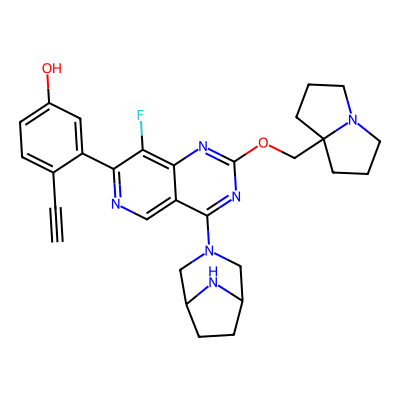

In [11]:
#@title Input molecule(s)
from io import BytesIO

try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if not IN_COLAB:
    try:
        from ipywidgets import FileUpload
        HAS_IPYWIDGETS = True
    except ImportError:
        HAS_IPYWIDGETS = False
else:
    HAS_IPYWIDGETS = False

input_method = 'SMILES' #@param ["SMILES", "CSV file containing SMILES", "MDL multiple SD file (*.sdf)"]
smiles_input = 'OC1=CC(=C(C=C1)C#C)C1=NC=C2C(=NC(OCC34CCCN3CCC4)=NC2=C1F)N1C[C@@H]2CC[C@H](C1)N2' #@param {type:"string"}

# Hide smiles_input field when not using SMILES input method
from IPython.display import HTML, Javascript
if IN_COLAB:
    display(HTML("""
    <script>
    (function() {
        function hideSmilesInput() {
            // Wait for form to be rendered
            setTimeout(function() {
                var form = document.querySelector('form[action*="form"]') ||
                          document.querySelector('.form-horizontal') ||
                          document.querySelector('form');
                if (!form) return;

                // Find input_method select
                var selects = form.querySelectorAll('select');
                var inputMethodSelect = null;
                for (var i = 0; i < selects.length; i++) {
                    var label = selects[i].getAttribute('aria-label') || '';
                    if (label.includes('input_method') || label.includes('Input method')) {
                        inputMethodSelect = selects[i];
                        break;
                    }
                }

                // Find smiles_input input
                var inputs = form.querySelectorAll('input[type="text"]');
                var smilesInput = null;
                var smilesInputRow = null;
                for (var i = 0; i < inputs.length; i++) {
                    var label = inputs[i].getAttribute('aria-label') || '';
                    if (label.includes('smiles_input') || label.includes('Smiles input')) {
                        smilesInput = inputs[i];
                        smilesInputRow = smilesInput.closest('tr') || smilesInput.closest('div') || smilesInput.parentElement;
                        break;
                    }
                }

                if (inputMethodSelect && smilesInputRow) {
                    function toggleSmilesInput() {
                        if (inputMethodSelect.value === 'SMILES') {
                            smilesInputRow.style.display = '';
                        } else {
                            smilesInputRow.style.display = 'none';
                        }
                    }
                    toggleSmilesInput();
                    inputMethodSelect.addEventListener('change', toggleSmilesInput);
                }
            }, 500);
        }
        hideSmilesInput();
        // Also try on form submission/change
        var observer = new MutationObserver(hideSmilesInput);
        observer.observe(document.body, { childList: true, subtree: true });
    })();
    </script>
    """))
else:
    # For Jupyter, the parameter will always be visible but can be ignored
    pass

moldf = []
m = None
inchi = None
smiles = None

if input_method == 'SMILES':
    mol = Chem.MolFromSmiles(smiles_input)
    if mol is not None:
        canon_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
        smiles = standardize_smiles(canon_smi)
        m = Chem.MolFromSmiles(smiles)
        if m is not None:
            inchi = str(Chem.MolToInchi(m))
            img = Draw.MolToImage(m, size=(400, 400))
            display_molecule_image(img)

elif input_method == 'CSV file containing SMILES':
    if IN_COLAB:
        uploaded = files.upload()
        if uploaded:
            file_name = list(uploaded.keys())[0]
            file_content = uploaded[file_name]
            df_ws = pd.read_csv(BytesIO(file_content), sep=';')
        else:
            df_ws = None
    elif HAS_IPYWIDGETS:
        file_upload = FileUpload(accept='.csv', multiple=False)
        display(file_upload)
        if file_upload.value:
            uploaded_file = list(file_upload.value.keys())[0]
            file_content = file_upload.value[uploaded_file]['content']
            df_ws = pd.read_csv(BytesIO(file_content), sep=';')
        else:
            df_ws = None
    else:
        df_ws = None

    if df_ws is not None:
        print('CHEMICAL STRUCTURE VALIDATION AND STANDARDIZATION:')

        count = 0
        failed_mols = []
        bad_index = []
        index = 0

        # First pass: validate SMILES
        total_mols = len(df_ws.SMILES)
        print(f'Validating SMILES: 0/{total_mols}')
        for i in tqdm(df_ws.SMILES, desc="Validating SMILES", total=total_mols, unit="molecule"):
            index += 1
            try:
                canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(i), isomericSmiles=False)
                df_ws.SMILES = df_ws.SMILES.replace(i, canon_smi)
            except:
                failed_mols.append(i)
                bad_index.append(index)
                count += 1
                df_ws.SMILES = df_ws.SMILES.replace(i, 'wrong_smiles')

        print(f'Original data: {len(df_ws)} molecules')
        print(f'Failed data: {count} molecules')

        # Display failed molecules from first pass
        if len(failed_mols) != 0:
            number = []
            for i in range(len(failed_mols)):
                number.append(str(i + 1))

            bad_molecules = pd.DataFrame({
                'No. failed molecule in original set': bad_index,
                'SMILES of wrong structure: ': failed_mols,
                'No.': number
            }, index=None)
            bad_molecules = bad_molecules.set_index('No.')
            display(bad_molecules)

        # Second pass: standardization
        moldf = []
        errors = []
        failed_mols_std = []
        bad_index_std = []

        valid_smiles = [r for r in df_ws.SMILES if r != 'wrong_smiles']
        total_valid = len(valid_smiles)

        valid_indices = [i for i, r in enumerate(df_ws.SMILES, start=1) if r != 'wrong_smiles']

        for idx, record in enumerate(tqdm(valid_smiles, desc="Standardizing molecules", total=total_valid, unit="molecule")):
            i = valid_indices[idx]
            try:
                mol_raw = Chem.MolFromSmiles(record, sanitize=False)
                Chem.SanitizeMol(mol_raw)
                canon_smi = Chem.MolToSmiles(mol_raw, isomericSmiles=False)
                standard_record = standardize_smiles(canon_smi)
                mol_obj = Chem.MolFromSmiles(standard_record, sanitize=True)
                moldf.append(mol_obj)
            except Exception as e:
                failed_mols_std.append(record)
                bad_index_std.append(i)
                errors.append(str(e))
                print(f"Failed at row {i}: {record} | {e}")

        print(f'Kept data: {len(moldf)} molecules')

        # Display failed molecules from standardization
        if len(failed_mols_std) != 0:
            all_failed = failed_mols + failed_mols_std
            all_bad_index = bad_index + bad_index_std
            all_errors = [''] * len(failed_mols) + errors

            bad_molecules = pd.DataFrame({
                'No. failed molecule in original set': all_bad_index,
                'SMILES of wrong structure: ': all_failed,
                'Error': all_errors
            }, index=None)
            bad_molecules = bad_molecules.set_index('No. failed molecule in original set')
            display(bad_molecules)

        m = None
        inchi = None
        smiles = None

elif input_method == 'MDL multiple SD file (*.sdf)':
    if IN_COLAB:
        uploaded = files.upload()
        if uploaded:
            file_name = list(uploaded.keys())[0]
            file_content = uploaded[file_name]
            supplier = Chem.ForwardSDMolSupplier(BytesIO(file_content), sanitize=False)
        else:
            supplier = None
    elif HAS_IPYWIDGETS:
        file_upload = FileUpload(accept='.sdf', multiple=False)
        display(file_upload)
        if file_upload.value:
            uploaded_file = list(file_upload.value.keys())[0]
            file_content = file_upload.value[uploaded_file]['content']
            supplier = Chem.ForwardSDMolSupplier(BytesIO(file_content), sanitize=False)
        else:
            supplier = None
    else:
        supplier = None

    if supplier is not None:
        print('CHEMICAL STRUCTURE VALIDATION AND STANDARDIZATION:')

        all_mols = []
        failed_mols = []
        wrong_structure = []
        wrong_smiles = []
        bad_index = []
        errors = []

        # First pass: validate SDF structures
        # Convert supplier to list to enable progress tracking
        supplier_list = list(supplier)
        total_sdf_mols = len(supplier_list)

        print(f'Validating SDF structures: 0/{total_sdf_mols}')
        for i, m_sdf in enumerate(tqdm(supplier_list, desc="Validating SDF structures", total=total_sdf_mols, unit="molecule")):
            structure = Chem.Mol(m_sdf)
            all_mols.append(structure)
            try:
                Chem.SanitizeMol(structure)
            except Exception as e:
                failed_mols.append(m_sdf)
                wrong_smiles.append(Chem.MolToSmiles(m_sdf) if m_sdf else '')
                wrong_structure.append(str(i + 1))
                bad_index.append(i)
                errors.append(str(e))
                print(f"Failed SDF at idx {i+1}: {wrong_smiles[-1]} | {e}")

        print(f'Original data: {len(all_mols)} molecules')
        print(f'Failed data: {len(failed_mols)} molecules')

        # Display failed molecules from first pass
        if len(failed_mols) != 0:
            number = []
            for i in range(len(failed_mols)):
                number.append(str(i + 1))

            bad_molecules = pd.DataFrame({
                'No. failed molecule in original set': wrong_structure,
                'SMILES of wrong structure: ': wrong_smiles,
                'No.': number
            }, index=None)
            bad_molecules = bad_molecules.set_index('No.')
            display(bad_molecules)

        # Remove failed molecules
        all_mols = [x for i, x in enumerate(all_mols) if i not in bad_index]
        records = [Chem.MolToSmiles(mol) for mol in all_mols]

        # Track original indices for molecules that passed first pass
        original_indices = [i for i in range(len(all_mols) + len(bad_index)) if i not in bad_index]

        # Second pass: standardization
        moldf = []
        total_records = len(records)
        print(f'Standardizing SDF molecules: 0/{total_records}')
        for idx, record in enumerate(tqdm(records, desc="Standardizing SDF molecules", total=total_records, unit="molecule")):
            try:
                mol_raw = Chem.MolFromSmiles(record, sanitize=False)
                Chem.SanitizeMol(mol_raw)
                canon_smi = Chem.MolToSmiles(mol_raw, isomericSmiles=False)
                standard_record = standardize_smiles(canon_smi)
                mol_obj = Chem.MolFromSmiles(standard_record, sanitize=True)
                moldf.append(mol_obj)
            except Exception as e:
                orig_idx = original_indices[idx] if idx < len(original_indices) else idx
                failed_mols.append(record)
                wrong_structure.append(str(orig_idx + 1))
                wrong_smiles.append(record)
                errors.append(str(e))
                print(f"Failed after SDF standardization at idx {orig_idx + 1}: {record} | {e}")

        print(f'Kept data: {len(moldf)} molecules')

        # Display all failed molecules
        if len(errors) > 0:
            bad_molecules = pd.DataFrame({
                'No. failed molecule in original set': wrong_structure,
                'SMILES of wrong structure: ': wrong_smiles,
                'Error': errors
            }, index=None)
            bad_molecules = bad_molecules.set_index('No. failed molecule in original set')
            display(bad_molecules)

        m = None
        inchi = None
        smiles = None


## Step 3. Select prediction type

Select prediction of KRAS inhibitor activity or substructural search for preferred or undesirable fragments.


In [8]:
#@title Select prediction type
prediction_type = 'Muegge rules, PAINS, Brenk structural alerts, Substructural search' #@param ["KRAS", "Muegge rules, PAINS, Brenk structural alerts, Substructural search"]


,SMILES,Predicted value pIC50,Applicability domain_KRAS,Experimental value value pIC50,STD,chembl_ID
1,C#Cc1ccc(O)cc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC34...,7.975,Inside AD,-,-,not detected


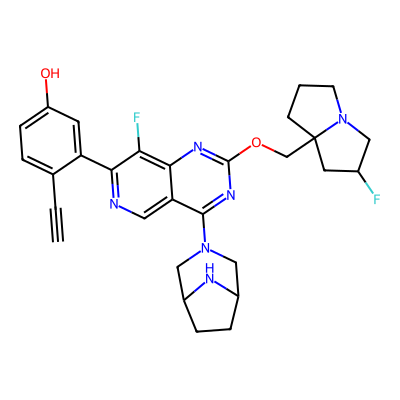

In [ ]:
#@title Step 4. Run predictions
if prediction_type == 'KRAS' and len(moldf) > 0:
    KRAS_set = set_molecules('KRAS', 'datasets/KRASS_exp_data_inchi.csv',
                            'Models/CatBoost_MF.pkl', 'Models/x_tr_MF.zip',
                            'x_tr_MF.csv', 3.91, None)
    results = KRAS_set.seach_predic_csv(moldf=moldf)
    display(results)
    # Add download button
    download_csv_button(results, filename='KRAS_predictions.csv')

elif prediction_type == 'KRAS' and m is not None:
    KRAS_one = one_molecules('KRAS', 'datasets/KRASS_exp_data_inchi.csv',
                            'Models/CatBoost_MF.pkl', 'Models/x_tr_MF.zip',
                            'x_tr_MF.csv', 3.91, m)
    results = KRAS_one.seach_predic(inchi=inchi, smiles=smiles)
    display(results)
    # Add download button
    download_csv_button(results, filename='KRAS_prediction_single.csv')
    img = Draw.MolToImage(m, size=(400, 400))
    buf = BytesIO()
    img.save(buf, format='PNG')
    buf.seek(0)
    display(IPImage(data=buf.read()))


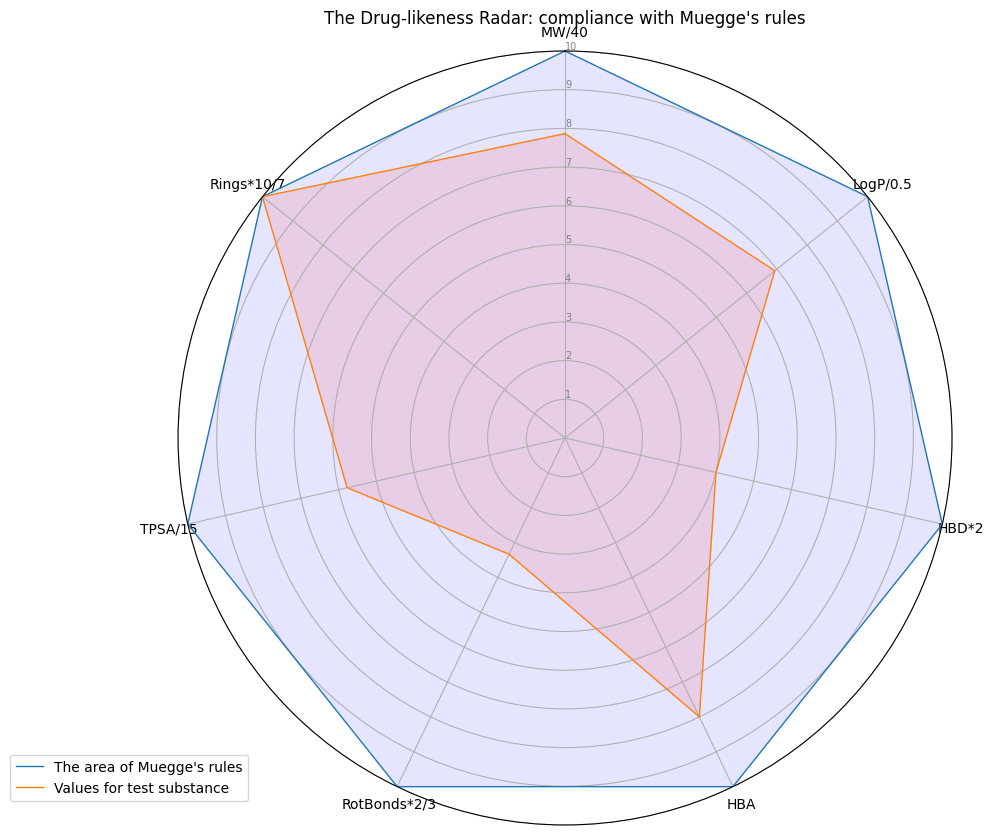

Val.,Values for the test substance,Reference values of Muegge rules
"Molecular weight(MW), Da",514.605,200-600
Octanol-water coefficient(LogP),3.4656,≤5
Number of hydrogen bond donors (HBD),2,≤5
Number of hydrogen bond acceptors(HBAs),8,≤10
Number of rotatable bonds,5,≤15
"Topological polar surface area (TPSA), Å²",86.64,≤150
Number of rings,7,≤7


The found fragments that increase the activity to inhibit KRAS: KRFP2949


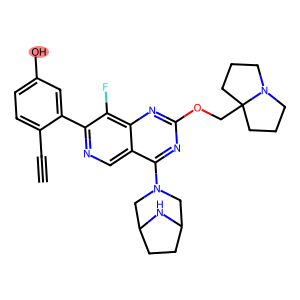

The found fragments that increase the activity to inhibit KRAS: KRFP3751


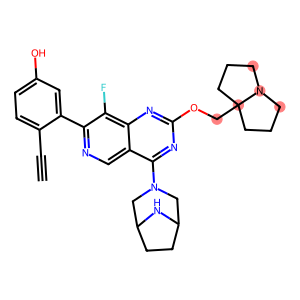

The found fragments that increase the activity to inhibit KRAS: KRFP3719


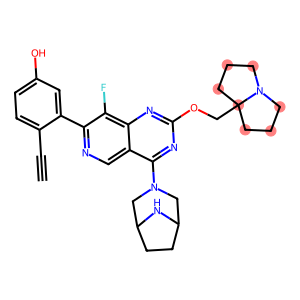

The found fragments that increase the activity to inhibit KRAS: KRFP1148


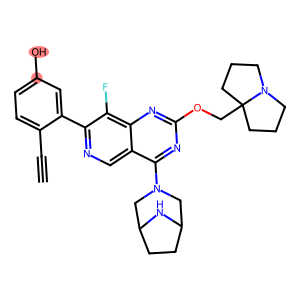

The found fragments that increase the activity to inhibit KRAS: PubchemFP714


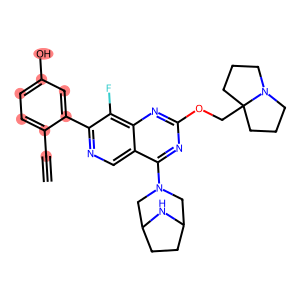

The found fragments that increase the activity to inhibit KRAS: PubchemFP659


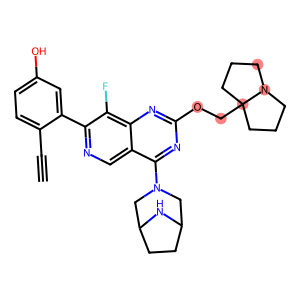

The found Brenk filter: triple-bond


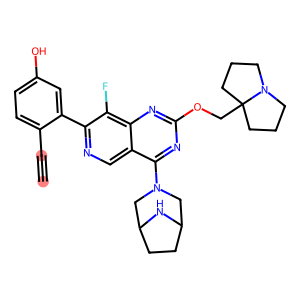

The PAINS are not found in the molecule.
The toxicophore alerts are not found in the molecule.


In [12]:
#@title Run structural analysis {run: "auto"}
if prediction_type == 'Muegge rules, PAINS, Brenk structural alerts, Substructural search' and m is not None:
    fig, descriptors = muegge(smiles)
    display(descriptors)
    Substructural_search_one = Med_chem_one('fragments that increase the activity to inhibit KRAS', ['vip'], m)
    Substructural_search_one.display_results()
    Brenk_SA = Med_chem_one('Brenk filter', ['unwanted'], m)
    Brenk_SA.display_results()
    Pains = Med_chem_one('PAINS', ['PAINS'], m)
    Pains.display_results()
    Toxic_alerts = Med_chem_one('toxicophore alerts', ['tox'], m)
    Toxic_alerts.display_results()

elif prediction_type == 'Muegge rules, PAINS, Brenk structural alerts, Substructural search' and len(moldf) > 0:
    alerts_data = load_structural_alerts()
    pains_substructures = alerts_data['pains']
    brenk_substructures = alerts_data['brenk']
    tox_substructures = alerts_data['tox']

    results = []
    for mol in moldf:
        if mol is None:
            continue
        smi = Chem.MolToSmiles(mol, isomericSmiles=False)
        pains_hits = [name for name, sub in pains_substructures if sub and mol.HasSubstructMatch(sub)]
        brenk_hits = [name for name, sub in brenk_substructures if sub and mol.HasSubstructMatch(sub)]
        tox_hits = [name for name, sub in tox_substructures if sub and mol.HasSubstructMatch(sub)]
        muegge_result = check_muegge_rule(mol)

        results.append({
            'SMILES': smi,
            'Muegge rules': muegge_result,
            'PAINS': 'yes' if pains_hits else 'no',
            'PAINS_names': ', '.join(pains_hits),
            'Brenk': 'yes' if brenk_hits else 'no',
            'Brenk_names': ', '.join(brenk_hits),
            'Toxic_alert': 'yes' if tox_hits else 'no',
            'Toxic_alert_names': ', '.join(tox_hits)
        })

    df_result = pd.DataFrame(results, columns=[
        'SMILES', 'Muegge rules', 'PAINS', 'PAINS_names',
        'Brenk', 'Brenk_names', 'Toxic_alert', 'Toxic_alert_names'
    ])
    display(df_result)
    # Add download button
    download_csv_button(df_result, filename='structural_analysis_results.csv')
